<a href="https://colab.research.google.com/github/roy644/Web-scraping-Data-analysis/blob/main/scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import pandas as pd
import requests
import json
import numpy as np

api_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

bls_key = '1b078617a6c94d6ab62e748cea831667'
#import config
key = '?registrationkey={}'.format(bls_key)

In [3]:
series_dict = {
    
    'CUUR0000SA0L1E': 'Consumer_price', 
    }

# Start year and end year
date_r = (1975, 2021)

# Handle dates
dates = [(str(date_r[0]), str(date_r[1]))]
while int(dates[-1][1]) - int(dates[-1][0]) > 10:
    dates = [(str(date_r[0]), str(date_r[0]+9))]
    d1 = int(dates[-1][0])
    while int(dates[-1][1]) < date_r[1]:
        d1 = d1 + 10
        d2 = min([date_r[1], d1+9])
        dates.append((str(d1),(d2))) 

In [4]:
df = pd.DataFrame()

for start, end in dates:
    # Submit the list of series as data
    data = json.dumps({
        "seriesid": list(series_dict.keys()),
        "startyear": start, "endyear": end})

    # Post request for the data
    p = requests.post(
        '{}{}'.format(api_url, key), 
        headers={'Content-type': 'application/json'}, 
        data=data).json()
    for s in p['Results']['series']:
        col = series_dict[s['seriesID']]
        for r in s['data']:
            date = pd.to_datetime('{} {}'.format(
                r['periodName'], r['year']))
            df.at[date, col] = float(r['value'])
df = df.sort_index()
# Output results
print('Post Request Status: {}'.format(p['status']))
df.tail(13)

Post Request Status: REQUEST_SUCCEEDED


,Consumer_price
2020-12-01,269.226
2021-01-01,269.755
2021-02-01,270.696
2021-03-01,271.713
2021-04-01,273.968
2021-05-01,275.893
2021-06-01,278.218
2021-07-01,279.146
2021-08-01,279.507
2021-09-01,279.884


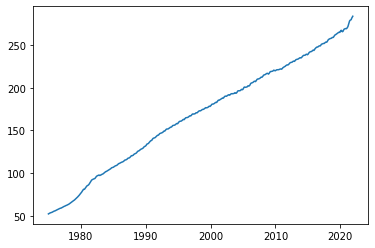

In [5]:
import matplotlib.pyplot as plt
plt.plot(df)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [7]:
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [8]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
print(X_train.shape), print(y_train.shape)

(265, 100)
(265,)


(None, None)

In [11]:
print(X_test.shape), print(ytest.shape)

(97, 100)
(97,)


(None, None)

In [12]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 8s 507ms/step - loss: 0.1093 - val_loss: 0.0057
Epoch 2/100
5/5 [==============================] - 1s 180ms/step - loss: 0.0187 - val_loss: 0.0157
Epoch 3/100
5/5 [==============================] - 1s 182ms/step - loss: 0.0056 - val_loss: 0.0951
Epoch 4/100
5/5 [==============================] - 1s 175ms/step - loss: 0.0082 - val_loss: 0.0250
Epoch 5/100
5/5 [==============================] - 1s 177ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 6/100
5/5 [==============================] - 1s 179ms/step - loss: 0.0030 - val_loss: 0.0305
Epoch 7/100
5/5 [==============================] - 1s 174ms/step - loss: 0.0022 - val_loss: 0.0386
Epoch 8/100
5/5 [==============================] - 1s 172ms/step - loss: 0.0017 - val_loss: 0.0140
Epoch 9/100
5/5 [==============================] - 1s 172ms/step - loss: 0.0015 - val_loss: 0.0087
Epoch 10/100
5/5 [==============================] - 1s 174ms/step - loss: 8.6264e-04 - val_loss: 0.0204
Epoch

In [18]:
import tensorflow as tf

In [19]:
tf.__version__


'2.9.2'

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

4/4 [==============================] - 0s 30ms/step


In [21]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [22]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

155.04620863625456

In [23]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

244.80072685642656

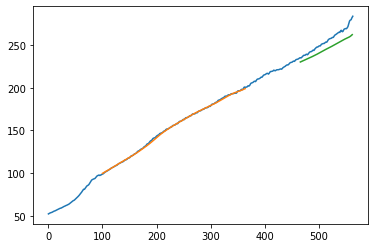

In [24]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [39]:
len(test_data)

198

In [65]:
x_input=test_data[98:].reshape(1,-1)
x_input.shape

(1, 100)

In [66]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [71]:
len(temp_input)

101

In [67]:
x_input

array([[0.78798315, 0.78962315, 0.78997272, 0.78892399, 0.79050788,
        0.79356345, 0.79718007, 0.79975227, 0.80199648, 0.8025489 ,
        0.8024669 , 0.80314879, 0.80550089, 0.80796951, 0.80725741,
        0.80521605, 0.80725741, 0.81086108, 0.81510781, 0.8182799 ,
        0.81964801, 0.82066221, 0.82101611, 0.821944  , 0.82499957,
        0.82770124, 0.82808966, 0.82681219, 0.83004471, 0.83501649,
        0.83794258, 0.84067879, 0.84306109, 0.84414004, 0.84392425,
        0.84622887, 0.84818392, 0.8502857 , 0.85032455, 0.84992318,
        0.85401885, 0.85859357, 0.85922799, 0.86074715, 0.86158009,
        0.86235262, 0.86201599, 0.86427745, 0.86635334, 0.86936144,
        0.86873133, 0.86901618, 0.87367721, 0.87861878, 0.88218793,
        0.88397897, 0.88589518, 0.88687918, 0.88761286, 0.88823865,
        0.89003832, 0.89277453, 0.89295579, 0.89286084, 0.89734493,
        0.90162618, 0.90474218, 0.9068828 , 0.90799627, 0.91052963,
        0.91220847, 0.91481088, 0.91633435, 0.91

In [70]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.78962315 0.78997272 0.78892399 0.79050788 0.79356345 0.79718007
 0.79975227 0.80199648 0.8025489  0.8024669  0.80314879 0.80550089
 0.80796951 0.80725741 0.80521605 0.80725741 0.81086108 0.81510781
 0.8182799  0.81964801 0.82066221 0.82101611 0.821944   0.82499957
 0.82770124 0.82808966 0.82681219 0.83004471 0.83501649 0.83794258
 0.84067879 0.84306109 0.84414004 0.84392425 0.84622887 0.84818392
 0.8502857  0.85032455 0.84992318 0.85401885 0.85859357 0.85922799
 0.86074715 0.86158009 0.86235262 0.86201599 0.86427745 0.86635334
 0.86936144 0.86873133 0.86901618 0.87367721 0.87861878 0.88218793
 0.88397897 0.88589518 0.88687918 0.88761286 0.88823865 0.89003832
 0.89277453 0.89295579 0.89286084 0.89734493 0.90162618 0.90474218
 0.9068828  0.90799627 0.91052963 0.91220847 0.91481088 0.91633435
 0.91865192 0.9188634  0.91811677 0.92273033 0.92818547 0.92837537
 0.92309717 0.9218456  0.92401643 0.93006284 0.93460735 0.93589345
 0.93707597 0.93770176 0.93663577 0.93891881 0.942

In [58]:
import matplotlib.pyplot as plt

In [59]:
len(df)

564

In [72]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

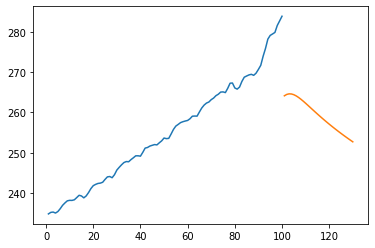

In [73]:
plt.plot(day_new,scaler.inverse_transform(df[464:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

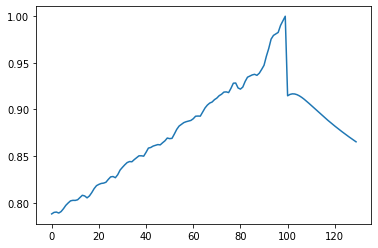

In [76]:
df1=df
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[464:])

In [77]:
df3=scaler.inverse_transform(df3).tolist()


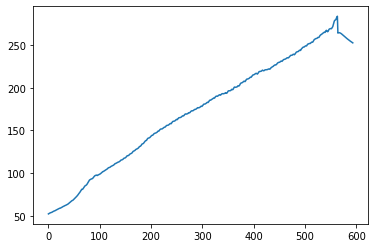

In [78]:
plt.plot(df3)